In [1]:
"""
Purpose: To test to see can get the neuron networkx
objects that can be used for training

Things to test: 
1) Axon Identification: Can the axon, dendrite, soma labels be extracted
2) Proofreading: Can the before proofread and 
after proofread objects be download and matched up for 
which ones were kept and which weren't (use split locations for this)
3) Can the cell type labels be downloaded 
"""

"\nPurpose: To test to see can get the neuron networkx\nobjects that can be used for training\n\nThings to test: \n1) Axon Identification: Can the axon, dendrite, soma labels be extracted\n2) Proofreading: Can the before proofread and \nafter proofread objects be download and matched up for \nwhich ones were kept and which weren't (use split locations for this)\n3) Can the cell type labels be downloaded \n"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/graph_tools/graph_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")

import datajoint_utils as du
from importlib import reload

WARNING - 2022-05-04 07:48:08,176 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-05-04 07:48:10,090 - settings - Setting enable_python_native_blobs to True
INFO - 2022-05-04 07:48:10,093 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-05-04 07:48:10,112 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-05-04 07:48:11,264 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-05-04 07:48:15,200 - utils - DataJointPlus version check failed.
INFO - 2022-05-04 07:48:17,110 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-05-04 07:48:17,149 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-05-04 07:48:17,234 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

In [4]:
from microns_morphology_api.schemas import minnie65_morphology as m65mor
m65mor.config.register_adapters(context=locals())
m65mor.config.register_externals()

from microns_morphology_api.schemas import minnie65_auto_proofreading as m65auto
m65auto.config.register_adapters(context=locals())
m65auto.config.register_externals()

In [5]:
from dataInterfaceMinnie65 import data_interface as hdju

In [6]:
import neuron_nx_utils as nxu
import networkx_utils as xu
import morphopy_utils as mpu

In [7]:
import dimensionality_reduction_ml as dru
import preprocessing_ml as preml
import pandas_ml as pdml
import pandas_utils as pu
import visualizations_ml as vml
import system_utils as su

# Cell Type Fine

In [8]:
# import cell_type_utils as ctu
# df_fine = ctu.cell_type_df_allen_bcm(return_cell_type_fine = True)

# Loading the Data

In [9]:
gnn_task = "cell_type_fine"
graph_label = "cell_type_fine_label"
data_file = "df_morphometrics.pbz2"
data_path = "./data/m65_full/"

data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134277239760,0,89719,LAYER_6,V1,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
1,864691134339067925,0,624899,LAYER_6,AL,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
2,864691134366116139,0,476756,WHITE_MATTER,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
3,864691134378215335,0,3799,LAYER_2/3,V1,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
4,864691134527727930,0,631380,WHITE_MATTER,RL,"{'normalized depth': 0.1, 'dendrite branch poi...",NaN
...,...,...,...,...,...,...,...
65211,864691137197345345,0,584463,LAYER_2/3,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
65212,864691137197345601,0,493570,LAYER_5,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
65213,864691137197345601,1,533074,LAYER_5,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN
65214,864691137197353281,0,591241,LAYER_5,RL,"{'normalized depth': 0.1, 'axon branch points'...",NaN


In [10]:
import pandas as pd
morpho_df = pd.DataFrame.from_records(data_df[gnn_task].to_list())
morpho_df

,normalized depth,dendrite branch points,dendrite width,dendrite depth,dendrite height,dendrite robust width,dendrite robust depth,dendrite robust height,dendrite x-bias,dendrite z-bias,...,mean initial segment radius,axon mean neurite radius,axon max Euclidean dist,axon first bifurcation moment,axon bifurcation standard deviation,Log1p fraction of axon above dendrite,Log1p fraction of axon below dendrite,Log1p fraction of dendrite above axon,Log1p fraction of dendrite below axon,EMD axon dendrite
0,0.1,0.0,3.99,3.58,3.11,3.56750,3.15000,2.96125,3.99,0.67,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,1.0,7.47,5.33,3.85,7.13050,5.10250,3.66100,0.09,2.27,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.1,0.0,5.38,2.03,2.44,4.94875,1.85375,2.39875,5.38,2.44,...,0.418563,0.253028,5.413141,-1.595000,0.365000,0.0,0.000000,0.000000,0.000000,0.057692
3,0.1,1.0,4.05,1.27,4.28,3.78925,1.05300,4.09275,4.05,4.28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.1,0.0,5.91,2.31,2.72,5.33750,2.11625,2.55250,5.91,2.72,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65211,0.1,31.0,279.24,231.35,404.55,187.17850,190.51675,356.37150,46.00,137.03,...,0.223780,0.254224,529.737154,-149.031045,111.574411,0.0,0.347744,0.000000,0.000000,0.611575
65212,0.1,36.0,304.87,282.51,463.49,218.45500,219.16375,419.74250,58.35,290.97,...,0.056055,0.248092,396.864273,-170.195400,142.070537,0.0,0.296443,0.000000,0.000000,0.588470
65213,0.1,9.0,175.46,195.59,608.98,135.87650,162.58950,590.35200,29.74,426.50,...,0.060299,0.060299,31.553791,NaN,NaN,0.0,0.000000,0.351808,0.105020,1.064736
65214,0.1,43.0,180.85,186.92,188.71,130.12825,148.45700,126.95700,43.39,-37.07,...,0.278268,0.150060,265.583777,-0.916768,40.924435,0.0,0.017213,0.000000,0.000000,0.439475


In [11]:
id_cols = ["segment_id","split_index","nucleus_id"]
cell_type_cols = ["cell_type_fine_label",]#"cell_type_coarse","table_of_origin"]

In [12]:
meta_data_cols = id_cols + cell_type_cols
meta_data_cols

['segment_id', 'split_index', 'nucleus_id', 'cell_type_fine_label']

In [13]:
bcm_features = [k for k in mpu.exc_features_berenslab if "apical" not in k]
bcm_features

['dendrite bifurcation standard deviation',
 'dendrite branch points',
 'dendrite first bifurcation moment',
 'dendrite height',
 'dendrite log max tortuosity',
 'dendrite log min tortuosity',
 'dendrite max Euclidean dist',
 'dendrite max branch order',
 'dendrite max path distance to soma',
 'dendrite max segment length',
 'dendrite mean neurite radius',
 'dendrite median path angle',
 'dendrite min branch angle',
 'dendrite robust height',
 'dendrite robust width',
 'dendrite tips',
 'dendrite total length',
 'dendrite width',
 'dendrite x-bias',
 'dendrite z-bias',
 'normalized depth',
 'soma radius',
 'stems',
 'stems exiting down',
 'stems exiting to the sides',
 'stems exiting up']

In [25]:
data_cols = bcm_features
df_cell_type_stats_filt = pd.concat([data_df[meta_data_cols],morpho_df[data_cols]],axis = 1)
df_cell_type_stats_filt

,segment_id,split_index,nucleus_id,cell_type_fine_label,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,...,dendrite total length,dendrite width,dendrite x-bias,dendrite z-bias,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up
0,864691134277239760,0,89719,NaN,NaN,0.0,NaN,3.11,0.426326,0.426326,...,8.341142,3.99,3.99,0.67,0.1,4.188726,1.0,0.000000,1.000000,0.000000
1,864691134339067925,0,624899,NaN,0.000000,1.0,1.950000,3.85,0.090295,0.000670,...,14.727391,7.47,0.09,2.27,0.1,1.788243,1.0,0.000000,1.000000,0.000000
2,864691134366116139,0,476756,NaN,NaN,0.0,NaN,2.44,0.169220,0.169220,...,7.128013,5.38,5.38,2.44,0.1,3.595072,1.0,0.000000,1.000000,0.000000
3,864691134378215335,0,3799,NaN,0.000000,1.0,2.660000,4.28,0.014546,0.000000,...,9.072503,4.05,4.05,4.28,0.1,3.595753,1.0,0.000000,1.000000,0.000000
4,864691134527727930,0,631380,NaN,NaN,0.0,NaN,2.72,0.341337,0.341337,...,8.664888,5.91,5.91,2.72,0.1,4.617534,1.0,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65211,864691137197345345,0,584463,NaN,82.169432,31.0,50.971034,404.55,2.075277,0.000000,...,4166.076773,279.24,46.00,137.03,0.1,10.196893,7.0,0.285714,0.428571,0.285714
65212,864691137197345601,0,493570,NaN,119.720139,36.0,52.314483,463.49,5.935429,0.000000,...,6849.260001,304.87,58.35,290.97,0.1,9.553507,9.0,0.111111,0.888889,0.000000
65213,864691137197345601,1,533074,NaN,165.802299,9.0,86.235000,608.98,0.505592,0.000000,...,1724.823965,175.46,29.74,426.50,0.1,7.020352,4.0,0.500000,0.250000,0.250000
65214,864691137197353281,0,591241,NaN,14.103478,43.0,4.111163,188.71,0.453799,0.000000,...,3063.059259,180.85,43.39,-37.07,0.1,9.573874,7.0,0.428571,0.428571,0.142857


# Debugging Missing Dendrite Properties from Inhibitory

In [26]:
# G = hdju.graph_obj_from_proof_stage(864691135162585389)

# ((m65auto.AutoProofreadNeuronMorphopy()).Object() & dict(segment_id=segment_id)).fetch1("morphometrics")

# segment_id = 864691135162585389
# split_index = 0

# hdju.morphometrics(segment_id,split_index)

# segment_id = 864691135162585389
# split_index = 0
# G = hdju.graph_obj_from_proof_stage(
#     segment_id,
#     split_index,
#     #add_on_auto_proof_filter = True
# )

# return_df = nxu.morphometrics(G)

# import morphopy_utils as mpu
# N =mpu.ntree_obj_from_swc(nxu.swc_df(G))



# curr_df = nxu.swc_df(G)

# df = nxu.morphometrics(G)
# df

# import neuron_nx_utils as nxu
# nxu.plot(G)

In [27]:
df_cell_type_stats_filt.query("cell_type_fine_label == 'BPC'")

,segment_id,split_index,nucleus_id,cell_type_fine_label,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,...,dendrite total length,dendrite width,dendrite x-bias,dendrite z-bias,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up
1614,864691135012356086,0,197718,BPC,133.533884,16.0,25.453333,557.66,0.342422,0.000000,...,2947.852124,155.74,49.92,196.76,0.1,6.922323,3.0,0.666667,0.000000,0.333333
2088,864691135012644086,0,292867,BPC,40.329987,18.0,-9.377500,235.37,0.625431,0.000000,...,1607.809490,118.65,46.45,-9.89,0.1,7.370840,3.0,0.333333,0.333333,0.333333
5350,864691135162585389,0,298961,BPC,64.737684,20.0,-6.673500,262.41,0.838399,0.000000,...,2031.394358,256.08,65.60,-20.85,0.1,7.633086,3.0,0.333333,0.333333,0.333333
7278,864691135213300280,0,268963,BPC,16.354303,10.0,5.832222,224.62,0.197581,0.009961,...,1757.709972,281.52,58.84,-67.82,0.1,8.898107,4.0,0.250000,0.500000,0.250000
8272,864691135272240913,0,296828,BPC,133.332552,11.0,-28.319091,612.13,0.325684,0.019831,...,1945.716422,282.42,12.58,-53.41,0.1,7.276138,2.0,0.500000,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59437,864691136436788382,0,262957,BPC,127.964501,12.0,157.717500,377.61,0.225506,0.004167,...,1159.306681,90.37,24.51,245.69,0.1,8.083419,2.0,0.500000,0.000000,0.500000
61146,864691136617221339,0,294418,BPC,68.425696,17.0,38.805882,270.57,0.466535,0.007079,...,1416.402184,155.99,35.29,81.91,0.1,8.443202,2.0,0.500000,0.000000,0.500000
62988,864691136812258931,0,260724,BPC,92.040905,20.0,-0.543684,437.53,0.440491,0.000000,...,2141.743665,232.18,17.02,44.83,0.1,7.106084,3.0,0.333333,0.000000,0.666667
63459,864691136903333554,0,234356,BPC,3.330341,6.0,-4.072500,296.13,0.173594,0.000000,...,1417.240491,343.71,112.23,9.47,0.1,8.353350,1.0,0.000000,1.000000,0.000000


In [28]:
import pandas_utils as pu
keep_idx = pu.find_all_rows_without_nan(df_cell_type_stats_filt[data_cols])
df_no_nan = df_cell_type_stats_filt.iloc[keep_idx,:]
df_no_nan

,segment_id,split_index,nucleus_id,cell_type_fine_label,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,...,dendrite total length,dendrite width,dendrite x-bias,dendrite z-bias,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up
1,864691134339067925,0,624899,NaN,0.000000,1.0,1.950000,3.85,0.090295,0.000670,...,14.727391,7.47,0.09,2.27,0.1,1.788243,1.0,0.000000,1.000000,0.000000
3,864691134378215335,0,3799,NaN,0.000000,1.0,2.660000,4.28,0.014546,0.000000,...,9.072503,4.05,4.05,4.28,0.1,3.595753,1.0,0.000000,1.000000,0.000000
5,864691134550853780,0,617351,NaN,0.000000,1.0,1.820000,2.84,0.016508,0.000000,...,7.727629,1.98,1.98,2.84,0.1,3.158164,1.0,1.000000,0.000000,0.000000
9,864691134628099318,0,758477,NaN,0.000000,1.0,3.590000,3.93,0.009393,0.000000,...,9.901837,3.45,0.59,3.93,0.1,4.519905,1.0,1.000000,0.000000,0.000000
12,864691134668951908,0,243011,NaN,0.000000,1.0,0.350000,6.94,0.182492,0.074517,...,35.741183,7.82,7.82,-2.00,0.1,5.830502,1.0,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65211,864691137197345345,0,584463,NaN,82.169432,31.0,50.971034,404.55,2.075277,0.000000,...,4166.076773,279.24,46.00,137.03,0.1,10.196893,7.0,0.285714,0.428571,0.285714
65212,864691137197345601,0,493570,NaN,119.720139,36.0,52.314483,463.49,5.935429,0.000000,...,6849.260001,304.87,58.35,290.97,0.1,9.553507,9.0,0.111111,0.888889,0.000000
65213,864691137197345601,1,533074,NaN,165.802299,9.0,86.235000,608.98,0.505592,0.000000,...,1724.823965,175.46,29.74,426.50,0.1,7.020352,4.0,0.500000,0.250000,0.250000
65214,864691137197353281,0,591241,NaN,14.103478,43.0,4.111163,188.71,0.453799,0.000000,...,3063.059259,180.85,43.39,-37.07,0.1,9.573874,7.0,0.428571,0.428571,0.142857


In [30]:
target_name = "cell_type_fine_label"
df = df_no_nan[data_cols + [target_name]]
df

import pandas_utils as pu
df = pu.filter_away_non_finite_rows(df)
df

,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,dendrite max Euclidean dist,dendrite max branch order,dendrite max path distance to soma,dendrite max segment length,...,dendrite width,dendrite x-bias,dendrite z-bias,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,cell_type_fine_label
128,114.315884,21.0,51.379524,473.08,0.290004,0.008740,383.569084,5.0,414.945328,286.509324,...,256.47,19.51,293.44,0.1,8.140259,8.0,0.250000,0.500000,0.250000,4P
160,16.925189,22.0,-3.298889,338.90,0.377764,0.001619,259.432957,6.0,307.049413,246.444654,...,211.92,43.88,171.54,0.1,8.856353,5.0,0.200000,0.400000,0.400000,23P
183,88.115086,20.0,68.312778,371.17,0.682446,0.004303,319.937713,10.0,354.581606,120.828785,...,186.55,26.73,258.05,0.1,8.447983,6.0,0.166667,0.833333,0.000000,5P_IT
220,25.752487,17.0,9.052143,513.40,0.306815,0.005450,291.786004,7.0,700.762945,285.792913,...,406.89,18.59,280.90,0.1,9.937995,6.0,0.166667,0.500000,0.333333,IT_short
228,17.787033,14.0,10.891429,135.17,1.818577,0.021084,170.001265,5.0,266.550761,92.706209,...,143.53,110.51,14.19,0.1,10.055069,7.0,0.428571,0.285714,0.285714,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65171,10.813547,12.0,1.159000,373.59,0.305752,0.000000,269.591249,4.0,654.147590,245.497496,...,223.08,14.44,161.37,0.1,7.290169,8.0,0.125000,0.500000,0.375000,4P
65173,21.963581,20.0,4.808947,151.59,0.580632,0.001714,222.216304,5.0,244.655790,162.931291,...,326.51,38.49,6.75,0.1,12.035514,7.0,0.142857,0.428571,0.428571,Unsure
65191,19.027690,12.0,5.590000,558.32,0.205164,0.000000,433.883224,5.0,1275.264249,371.101440,...,419.21,82.81,364.94,0.1,7.443242,6.0,0.166667,0.833333,0.000000,5P_NP
65202,23.435103,18.0,12.049375,343.87,2.014913,0.000000,245.465073,7.0,552.327586,238.922168,...,430.40,25.04,135.91,0.1,8.929766,5.0,0.200000,0.600000,0.200000,6P


# Dim Reduction

In [21]:
"""
Source code: https://github.com/berenslab/mini-atlas/blob/master/code/phenotype-tsne.ipynb
saved_in file: m1_patchseq_morph_features

"""

'\nSource code: https://github.com/berenslab/mini-atlas/blob/master/code/phenotype-tsne.ipynb\nsaved_in file: m1_patchseq_morph_features\n\n'

In [37]:
import pandas_utils as pu
embedding_df = df
target_name = "cell_type_label"
embedding_df = pu.rename_columns(embedding_df,
                                dict(cell_type_fine_label=target_name))

#need to scale
embedding_df = preml.scale_df(
    embedding_df,target_name=target_name)
embedding_df

,dendrite bifurcation standard deviation,dendrite branch points,dendrite first bifurcation moment,dendrite height,dendrite log max tortuosity,dendrite log min tortuosity,dendrite max Euclidean dist,dendrite max branch order,dendrite max path distance to soma,dendrite max segment length,...,dendrite width,dendrite x-bias,dendrite z-bias,normalized depth,soma radius,stems,stems exiting down,stems exiting to the sides,stems exiting up,cell_type_label
0,1.235970,-0.232905,0.691717,0.683097,-0.386554,1.688785,0.650029,-0.858492,-0.157699,0.797871,...,0.203568,-0.351068,0.655628,0.0,-0.141373,1.146401,0.210411,-0.251992,0.142432,4P
1,-1.069675,-0.147176,-1.013943,-0.272113,-0.329091,-0.115829,-0.387195,-0.552565,-0.586597,0.348549,...,-0.479550,0.508796,-0.131841,0.0,0.190075,-0.617809,-0.221141,-0.786820,1.082041,23P
2,0.615688,-0.318635,1.219940,-0.042387,-0.129595,0.564414,0.118355,0.671144,-0.397651,-1.060223,...,-0.868567,-0.096319,0.427010,0.0,0.001059,-0.029739,-0.508841,1.530770,-1.423583,5P_IT
3,-0.860696,-0.575823,-0.628660,0.970129,-0.375547,0.855113,-0.116868,-0.246638,0.978459,0.789836,...,2.510070,-0.383529,0.574620,0.0,0.690718,-0.029739,-0.508841,-0.251992,0.664437,IT_short
4,-1.049271,-0.833011,-0.571285,-1.722441,0.614307,4.816625,-1.134445,-0.858492,-0.747584,-1.375615,...,-1.528225,2.859749,-1.148316,0.0,0.744906,0.558331,1.751665,-1.398052,0.366148,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,-1.214363,-1.004469,-0.874882,-0.025160,-0.376243,-0.526059,-0.302317,-1.164419,0.793158,0.337927,...,-0.308425,-0.529956,-0.197539,0.0,-0.534840,1.146401,-0.868467,-0.251992,0.925439,4P
3417,-0.950395,-0.318635,-0.761024,-1.605549,-0.196260,-0.091688,-0.698160,-0.858492,-0.834619,-0.588047,...,1.277544,0.318617,-1.196378,0.0,1.661564,0.558331,-0.714342,-0.634012,1.261014,Unsure
3418,-1.019900,-1.004469,-0.736659,1.289909,-0.442105,-0.526059,1.070430,-0.858492,3.262167,1.746565,...,2.698982,1.882390,1.117515,0.0,-0.463990,-0.029739,-0.508841,1.530770,-1.423583,5P_NP
3419,-0.915558,-0.490093,-0.535163,-0.236733,0.742862,-0.526059,-0.503904,-0.246638,0.388411,0.264185,...,2.870567,-0.155949,-0.362010,0.0,0.224054,-0.617809,-0.221141,0.282837,-0.170771,6P


In [38]:
# df_scaled = df_scaled.replace(np.nan,"Unknown")
# df_scaled

# Step 6: Plotting Embeddings

In [39]:
%matplotlib notebook
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [42]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,target_name)

In [43]:
X = X_data#[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels#[labeled_mask_plotting].to_numpy()

# Prep) PCA Preprocessing

<IPython.core.display.Javascript object>


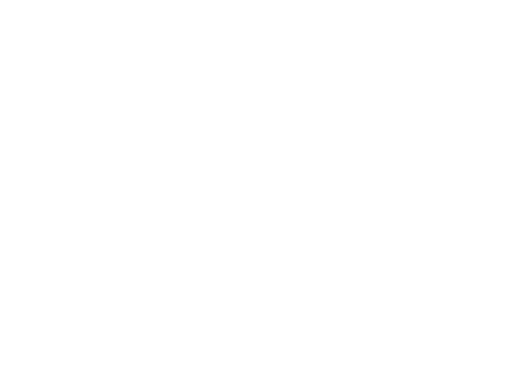

<IPython.core.display.Javascript object>


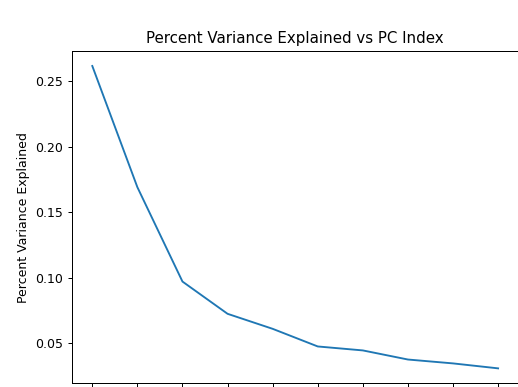

In [44]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [45]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

<IPython.core.display.Javascript object>


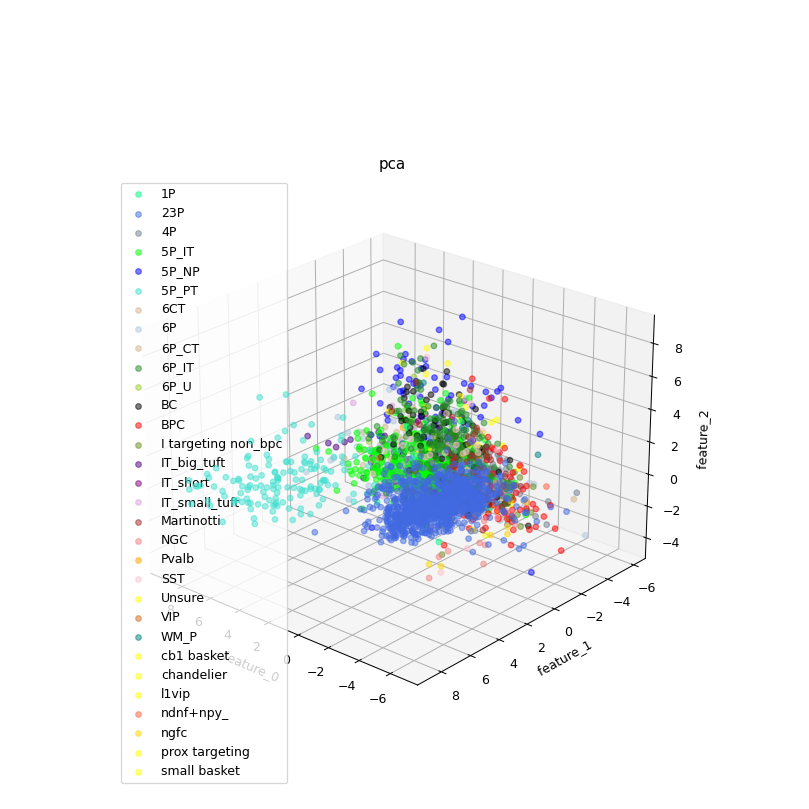

array([[ 1.06242589, -1.26768911, -0.62470905],
       [-1.69776736, -0.34984765, -0.11662094],
       [ 0.52677324, -0.41858278, -1.31199134],
       ...,
       [ 3.04004944, -2.09865762,  5.03475688],
       [-0.01448289,  0.46621888,  3.72724314],
       [-2.62021573, -2.25719951, -1.22033222]])

In [46]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
dru.dimensionality_reduction_by_method(
    method="pca",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# b) UMAP

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9100. The TBB threading layer is disabled.
  warnings.warn(problem)


<IPython.core.display.Javascript object>


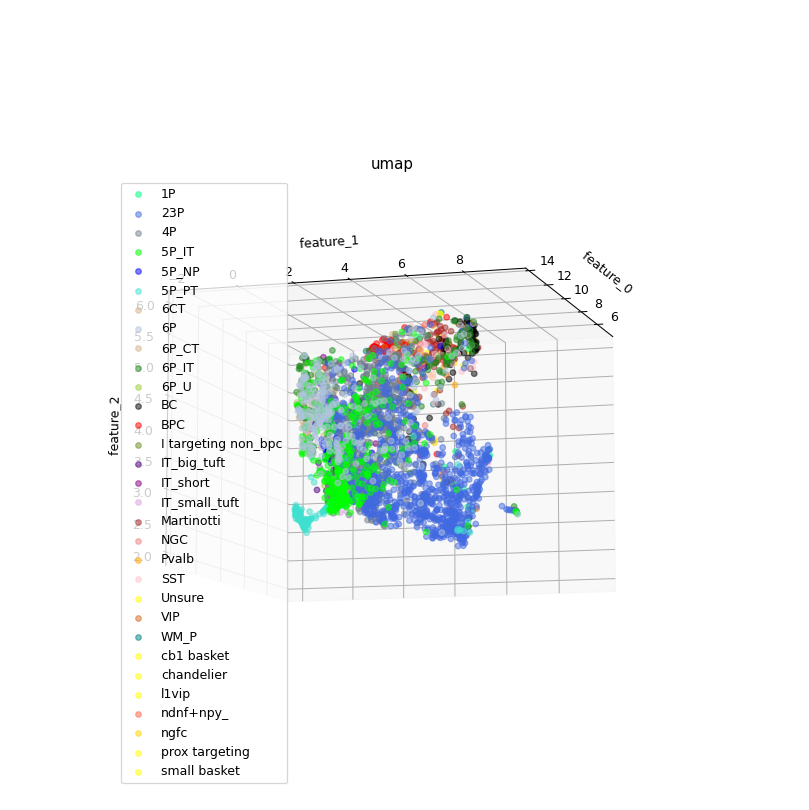

array([[11.969192 ,  2.249708 ,  3.9054675],
       [12.196378 ,  4.453919 ,  4.364548 ],
       [10.448637 ,  1.6163802,  4.136577 ],
       ...,
       [ 8.152013 ,  1.140325 ,  4.4094753],
       [11.01961  ,  6.7623816,  5.362134 ],
       [13.390057 ,  4.607231 ,  5.1008005]], dtype=float32)

In [47]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="umap",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# Isomap

<IPython.core.display.Javascript object>


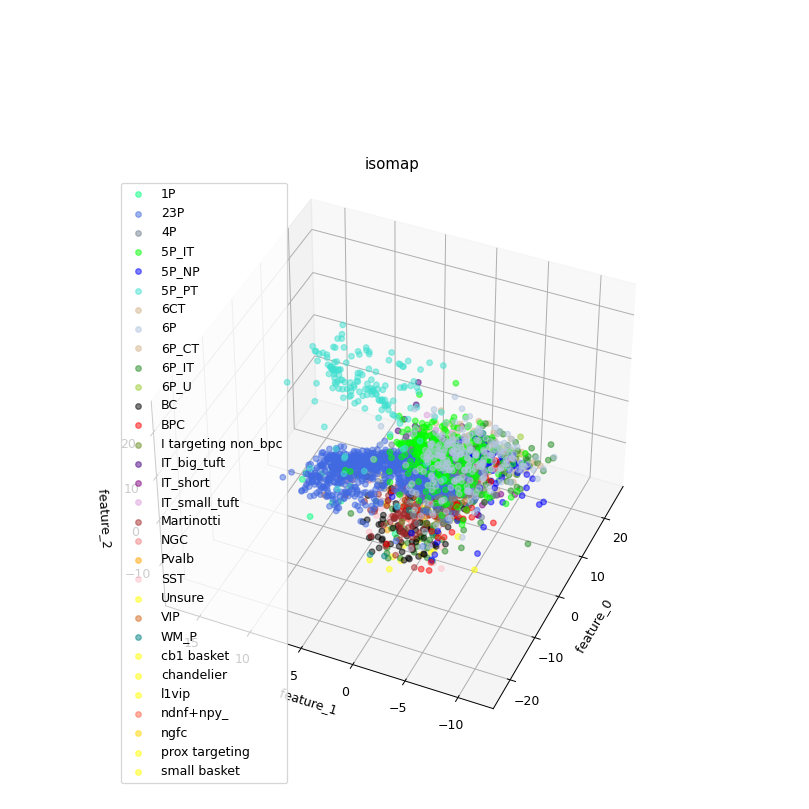

array([[  3.300768  ,  -0.48266766,   2.91290429],
       [ -3.39278754,  -3.62288548,   0.39597399],
       [  4.18965641,  -0.0476749 ,   1.30287732],
       ...,
       [  7.36091603,  -1.94812116,  -5.43587137],
       [ -1.86493961,  -0.64687991, -12.38143977],
       [ -4.1555456 ,  -4.14599298,   5.42273803]])

In [48]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="isomap",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# TSNE

<IPython.core.display.Javascript object>


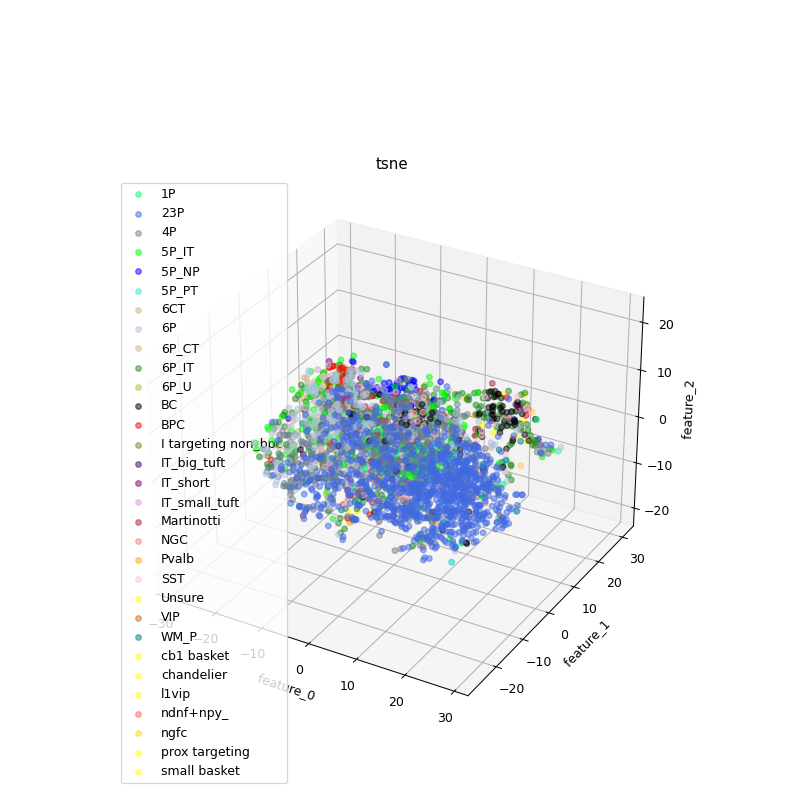

array([[-12.207441 ,  -6.491233 ,   4.1847935],
       [ -0.3855996,  -7.5156207,   8.458924 ],
       [-12.631849 ,   4.1946683,  -6.4727793],
       ...,
       [-11.180234 ,  26.753897 ,  -0.5205977],
       [ 16.81594  ,   5.931892 ,  10.865094 ],
       [ -3.7359862, -13.09255  ,  19.40137  ]], dtype=float32)

In [49]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =3,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

<IPython.core.display.Javascript object>


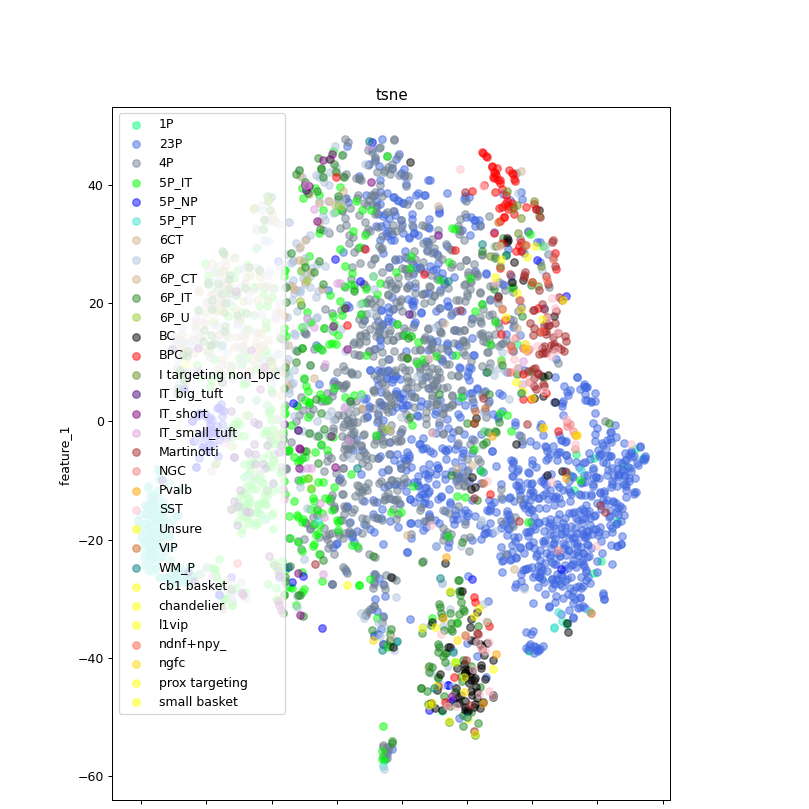

array([[-11.103874 ,  31.864809 ],
       [ 12.962004 ,  23.204391 ],
       [-35.75181  ,   8.1175375],
       ...,
       [-64.004585 ,  -3.327794 ],
       [ 15.560577 , -38.734375 ],
       [ 30.559484 ,  39.316593 ]], dtype=float32)

In [50]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

<IPython.core.display.Javascript object>


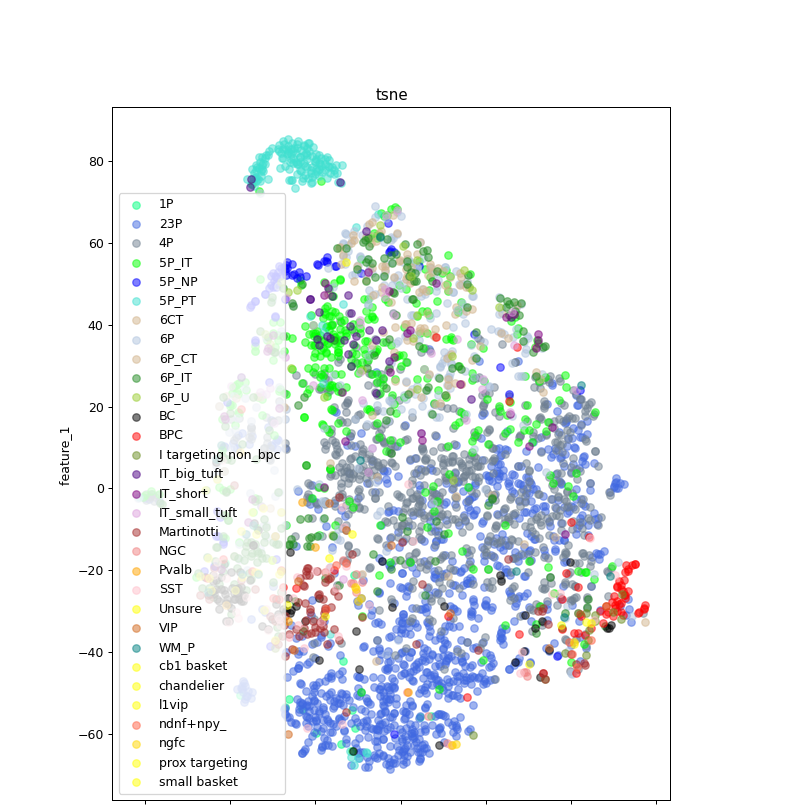

array([[ 32.54538  ,  17.163656 ],
       [ 24.945778 , -20.483648 ],
       [  0.8434721,  22.34874  ],
       ...,
       [-30.926682 ,  49.071953 ],
       [-36.448307 , -11.114445 ],
       [ 52.61676  , -26.190685 ]], dtype=float32)

In [51]:
import dimensionality_reduction_ml as dru
dru.dimensionality_reduction_by_method(
    method="tsne",
    X=X_pca[y!= "Unknown"],
    y = y[y != "Unknown"],
    n_components =2,
    plot=True,
    plot_kwargs=dict(
    target_to_color = ctu.cell_type_fine_color_map,
        ndim = 3,
    )
    
)

# Can do controls based on the average traits